In [26]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [27]:
#Import packages
import time
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import pickle
import random
import logging
import tensorflow as tf
import matplotlib.pyplot as plt
import segmentation_models as sm

import utils.parameters
from utils.model import s3ar_unet
from utils.save_load import save_h, load_h
from utils.eval import cost_compute, jacard_coef
from utils.test_loader import test_loader, read_image, read_mask, mask_parse

from utils.layers import (squeeze_excite_block, 
                          spatial_squeeze_excite_block, 
                          channel_spatial_squeeze_excite,
                          stem_block,
                          resnet_block,
                          attention_block,
                          single_conv_block,
                          fsm)

from utils.preprocess import (atoi, 
                              natural_keys, 
                              data_loader, 
                              read_image, 
                              read_mask, 
                              tf_parse, 
                              tf_dataset, 
                              read_and_rgb)

from glob import glob
from PIL import Image
from math import ceil
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import MeanIoU

from skimage import io
from skimage.io import imsave
from skimage.transform import resize
from tensorflow.keras.utils import normalize
from skimage.exposure import rescale_intensity
from skimage.segmentation import mark_boundaries
print("Packages successfully loaded")

tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

Packages successfully loaded


In [28]:
print("JIT activo?", tf.config.optimizer.get_jit())  # debería imprimir False o None

# (opcional) forzar por API también
tf.config.optimizer.set_jit(False)
print("JIT activo (tras set_jit)?", tf.config.optimizer.get_jit())


JIT activo? 
JIT activo (tras set_jit)? 


# PARAMETER TWEAKING

In [29]:
#Parameter configurations
#Class
num_classes = 1

model_name = 'SeARUNet'
experiment_number = '3_roi_1.1'

model_name = model_name + '-' + experiment_number

save_name =  model_name

print('Model to be trained is:', model_name)
print('Model is to be saved as:', save_name)

Model to be trained is: SeARUNet-3_roi_1.1
Model is to be saved as: SeARUNet-3_roi_1.1


In [30]:
#Set hyper-parameters
batch_size = 16
epochs = 25
optimizer = RMSprop
learning_rate = 1e-3
smooth = 1.0

print('Batch size is set to:', batch_size)
print('Epochs is set to:', epochs)
print('Optimizer is set to:', optimizer.__name__)
print('Learning Rate is set to:', learning_rate)
print('Smoothing is set to:', smooth)

Batch size is set to: 16
Epochs is set to: 25
Optimizer is set to: RMSprop
Learning Rate is set to: 0.001
Smoothing is set to: 1.0


# DATASET PREPARATION

In [31]:
import re

PATH = "/home/vplab-2024/Desktop/VoiceLab/segmentation_glottis/datasets/BAGLS_VMUNET/training"  

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]

images = sorted(glob(os.path.join(PATH, "*[!_seg].png")))  # Imágenes que no tienen '_seg' en el nombre
masks = sorted(glob(os.path.join(PATH, "*_seg.png")))      # Máscaras que tienen '_seg' en el nombre

images.sort(key=natural_keys)
masks.sort(key=natural_keys)

print(f"Number of images: {len(images)}")
print(f"Number of masks: {len(masks)}")


Number of images: 55750
Number of masks: 55750


# Preprocess

In [32]:
#split with labels
(train_x, train_y), (val_x, val_y)= data_loader(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(val_x))

Training data:  52963
Validation data:  2787


# Check Train Data

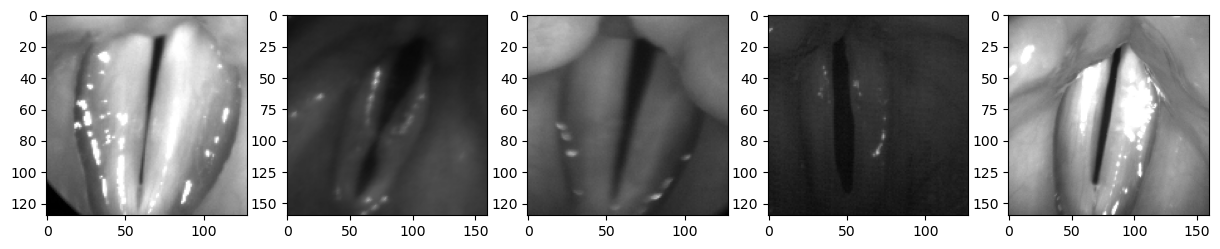

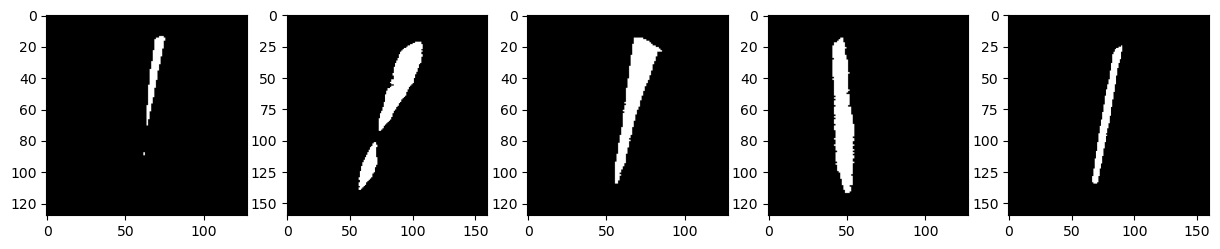

In [33]:
#Train data viewer
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 5, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 5, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 5, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

a = fig.add_subplot(1, 5, 5)
imgplot = plt.imshow(read_and_rgb(train_x[4]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 5, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 5, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 5, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 5, 5)
imgplot = plt.imshow(read_and_rgb(train_y[4]))
imgplot.set_clim(0.0, 1.4)

# Check Validation Data

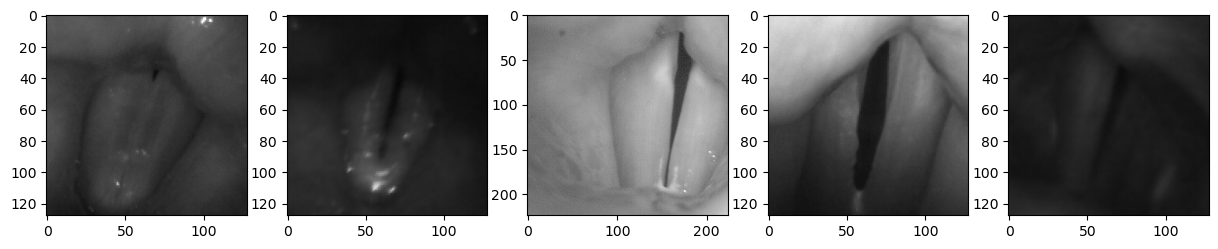

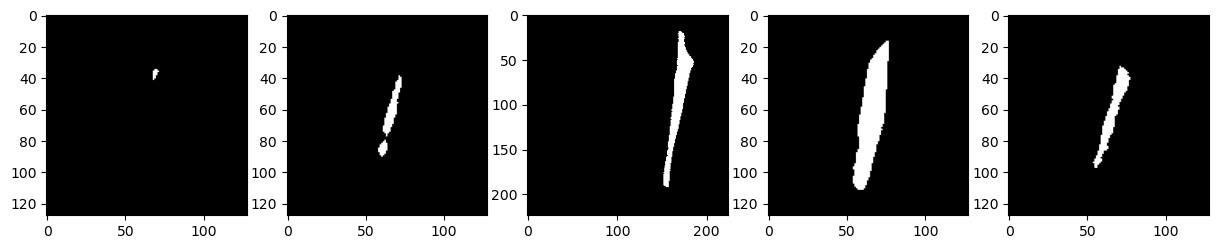

In [34]:
#Val data viewer
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
imgplot = plt.imshow(read_and_rgb(val_x[0]))

a = fig.add_subplot(1, 5, 2)
imgplot = plt.imshow(read_and_rgb(val_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 5, 3)
imgplot = plt.imshow(read_and_rgb(val_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 5, 4)
imgplot = plt.imshow(read_and_rgb(val_x[3]))
imgplot.set_clim(0.0, 2.1)

a = fig.add_subplot(1, 5, 5)
imgplot = plt.imshow(read_and_rgb(val_x[4]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
imgplot = plt.imshow(read_and_rgb(val_y[0]))

a = fig.add_subplot(1, 5, 2)
imgplot = plt.imshow(read_and_rgb(val_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 5, 3)
imgplot = plt.imshow(read_and_rgb(val_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 5, 4)
imgplot = plt.imshow(read_and_rgb(val_y[3]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 5, 5)
imgplot = plt.imshow(read_and_rgb(val_y[4]))
imgplot.set_clim(0.0, 1.4)

# Produce Datasets

In [35]:
#Create datasets
train_dataset = tf_dataset(train_x, train_y, batch=8)
val_dataset = tf_dataset(val_x, val_y, batch=8)

# BUILD AND COMPILE MODEL

In [36]:
#Initialize the model
print('-'*30)
print('Creating model...')
print('-'*30)
model = s3ar_unet()
model.summary()

------------------------------
Creating model...
------------------------------
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 32), dtype=tf.float32, name=None), name='re_lu_76/Relu6:0', description="created by layer 're_lu_76'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 32), dtype=tf.float32, name=None), name='re_lu_83/Relu6:0', description="created by layer 're_lu_83'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 16), dtype=tf.float32, name=None), name='re_lu_90/Relu6:0', description="created by layer 're_lu_90'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 8), dtype=tf.float32, name=None), name='re_lu_97/Relu6:0', description="created by layer 're_lu_97'")
KerasTensor(type_spec=TensorSpec(shape=(None, 2, 2, 8), dtype=tf.float32, name=None), name='re_lu_101/Relu6:0', description="created by layer 're_lu_101'")
Model: "S3AR_UNet"
__________________________________________________________________________________________________
 Layer (type)          

                                                                                                  
 batch_normalization_48 (Ba  (None, 32, 32, 32)           128       ['separable_conv2d_105[0][0]']
 tchNormalization)                                                                                
                                                                                                  
 add_47 (Add)                (None, 32, 32, 32)           0         ['separable_conv2d_104[0][0]',
                                                                     'batch_normalization_48[0][0]
                                                                    ']                            
                                                                                                  
 global_average_pooling2d_2  (None, 32)                   0         ['add_47[0][0]']              
 0 (GlobalAveragePooling2D)                                                                       
          

                                                                    ']                            
                                                                                                  
 add_50 (Add)                (None, 32, 32, 32)           0         ['re_lu_76[0][0]',            
                                                                     'add_48[0][0]']              
                                                                                                  
 separable_conv2d_113 (Sepa  (None, 32, 32, 8)            1064      ['add_50[0][0]']              
 rableConv2D)                                                                                     
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 8)            0         ['separable_conv2d_113[0][0]']
 g2D)                                                                                             
          

                                                                                                  
 dot_12 (Dot)                (None, 256, 256)             0         ['reshape_46[0][0]',          
                                                                     'reshape_47[0][0]']          
                                                                                                  
 separable_conv2d_121 (Sepa  (None, 16, 16, 8)            144       ['re_lu_81[0][0]']            
 rableConv2D)                                                                                     
                                                                                                  
 lambda_6 (Lambda)           (None, 256, 256)             0         ['dot_12[0][0]']              
                                                                                                  
 reshape_48 (Reshape)        (None, 256, 8)               0         ['separable_conv2d_121[0][0]']
          

 rableConv2D)                                                                                     
                                                                                                  
 multiply_48 (Multiply)      (None, 8, 8, 16)             0         ['add_55[0][0]',              
                                                                     'dense_45[0][0]']            
                                                                                                  
 multiply_49 (Multiply)      (None, 8, 8, 16)             0         ['add_55[0][0]',              
                                                                     'separable_conv2d_128[0][0]']
                                                                                                  
 add_56 (Add)                (None, 8, 8, 16)             0         ['multiply_48[0][0]',         
                                                                     'multiply_49[0][0]']         
          

 tchNormalization)                                                                                
                                                                                                  
 re_lu_92 (ReLU)             (None, 4, 4, 8)              0         ['batch_normalization_62[0][0]
                                                                    ']                            
                                                                                                  
 separable_conv2d_138 (Sepa  (None, 4, 4, 8)              80        ['max_pooling2d_6[0][0]']     
 rableConv2D)                                                                                     
                                                                                                  
 separable_conv2d_137 (Sepa  (None, 4, 4, 8)              272       ['re_lu_92[0][0]']            
 rableConv2D)                                                                                     
          

                                                                                                  
 separable_conv2d_145 (Sepa  (None, 4, 4, 8)              140       ['add_61[0][0]']              
 rableConv2D)                                                                                     
                                                                                                  
 re_lu_96 (ReLU)             (None, 4, 4, 8)              0         ['separable_conv2d_145[0][0]']
                                                                                                  
 batch_normalization_65 (Ba  (None, 4, 4, 8)              32        ['re_lu_96[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 re_lu_97 (ReLU)             (None, 4, 4, 8)              0         ['batch_normalization_65[0][0]
          

 reshape_64 (Reshape)        (None, 1, 1, 8)              0         ['global_average_pooling2d_24[
                                                                    0][0]']                       
                                                                                                  
 dense_48 (Dense)            (None, 1, 1, 1)              8         ['reshape_64[0][0]']          
                                                                                                  
 re_lu_102 (ReLU)            (None, 1, 1, 1)              0         ['dense_48[0][0]']            
                                                                                                  
 dense_49 (Dense)            (None, 1, 1, 8)              8         ['re_lu_102[0][0]']           
                                                                                                  
 separable_conv2d_154 (Sepa  (None, 2, 2, 1)              16        ['separable_conv2d_153[0][0]']
 rableConv

 rableConv2D)                                                                                     
                                                                                                  
 batch_normalization_71 (Ba  (None, 4, 4, 8)              32        ['separable_conv2d_159[0][0]']
 tchNormalization)                                                                                
                                                                                                  
 re_lu_108 (ReLU)            (None, 4, 4, 8)              0         ['batch_normalization_71[0][0]
                                                                    ']                            
                                                                                                  
 separable_conv2d_161 (Sepa  (None, 4, 4, 8)              80        ['add_68[0][0]']              
 rableConv2D)                                                                                     
          

                                                                                                  
 add_72 (Add)                (None, 4, 4, 8)              0         ['up_sampling2d_6[0][0]',     
                                                                     'separable_conv2d_166[0][0]']
                                                                                                  
 re_lu_113 (ReLU)            (None, 4, 4, 8)              0         ['add_72[0][0]']              
                                                                                                  
 separable_conv2d_167 (Sepa  (None, 4, 4, 8)              80        ['re_lu_113[0][0]']           
 rableConv2D)                                                                                     
                                                                                                  
 activation_6 (Activation)   (None, 4, 4, 8)              0         ['separable_conv2d_167[0][0]']
          

                                                                                                  
 separable_conv2d_172 (Sepa  (None, 8, 8, 1)              32        ['add_75[0][0]']              
 rableConv2D)                                                                                     
                                                                                                  
 multiply_64 (Multiply)      (None, 8, 8, 16)             0         ['add_75[0][0]',              
                                                                     'dense_59[0][0]']            
                                                                                                  
 multiply_65 (Multiply)      (None, 8, 8, 16)             0         ['add_75[0][0]',              
                                                                     'separable_conv2d_172[0][0]']
                                                                                                  
 add_76 (A

 multiply_70 (Multiply)      (None, 8, 8, 8)              0         ['multiply_68[0][0]',         
                                                                     'separable_conv2d_178[0][0]']
                                                                                                  
 add_79 (Add)                (None, 8, 8, 8)              0         ['multiply_69[0][0]',         
                                                                     'multiply_70[0][0]']         
                                                                                                  
 conv2d_transpose_6 (Conv2D  (None, 16, 16, 8)            264       ['add_79[0][0]']              
 Transpose)                                                                                       
                                                                                                  
 add_80 (Add)                (None, 16, 16, 8)            0         ['conv2d_transpose_6[0][0]',  
          

 rableConv2D)                                                                                     
                                                                                                  
 multiply_73 (Multiply)      (None, 16, 16, 8)            0         ['separable_conv2d_183[0][0]',
                                                                     'dense_67[0][0]']            
                                                                                                  
 multiply_74 (Multiply)      (None, 16, 16, 8)            0         ['separable_conv2d_183[0][0]',
                                                                     'separable_conv2d_184[0][0]']
                                                                                                  
 depthwise_conv2d_9 (Depthw  (None, 8, 8, 8)              520       ['separable_conv2d_185[0][0]']
 iseConv2D)                                                                                       
          

                                                                                                  
 batch_normalization_87 (Ba  (None, 32, 32, 32)           128       ['separable_conv2d_191[0][0]']
 tchNormalization)                                                                                
                                                                                                  
 add_86 (Add)                (None, 32, 32, 32)           0         ['separable_conv2d_190[0][0]',
                                                                     'batch_normalization_87[0][0]
                                                                    ']                            
                                                                                                  
 global_average_pooling2d_3  (None, 32)                   0         ['add_86[0][0]']              
 5 (GlobalAveragePooling2D)                                                                       
          

 multiply_82 (Multiply)      (None, 128, 128, 67)         0         ['concatenate_3[0][0]',       
                                                                     'dense_75[0][0]']            
                                                                                                  
 multiply_83 (Multiply)      (None, 128, 128, 67)         0         ['concatenate_3[0][0]',       
                                                                     'separable_conv2d_196[0][0]']
                                                                                                  
 add_89 (Add)                (None, 128, 128, 67)         0         ['multiply_82[0][0]',         
                                                                     'multiply_83[0][0]']         
                                                                                                  
 separable_conv2d_197 (Sepa  (None, 128, 128, 1)          1743      ['add_89[0][0]']              
 rableConv

In [37]:
#Calculate the cost

#cost_compute(model)

# COMPILE MODEL

In [38]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

model.compile(
    optimizer=opt,
    loss=tf.keras.losses.BinaryFocalCrossentropy(),
    metrics=[
        'accuracy',
        sm.metrics.Precision(threshold=0.5, smooth=smooth),
        sm.metrics.Recall(threshold=0.5, smooth=smooth),
        sm.metrics.FScore(threshold=0.5, smooth=smooth, name='F1/DSC'),
        sm.metrics.IOUScore(threshold=0.5, smooth=smooth, name='IOU/JaccardIndex'),
        sm.metrics.IOUScore(threshold=0.5, smooth=smooth, per_image=True, name='MeanIOU'),
    ],
    jit_compile=False,   # <-- CLAVE para evitar XLA
)

In [39]:
#Compile the model
#optimizer = tf.keras.optimizers.Adam
#model.compile(optimizer=optimizer(learning_rate=learning_rate), 
#              loss=tf.keras.losses.BinaryFocalCrossentropy(), 
#              metrics=['accuracy', 
#                       sm.metrics.Precision(threshold = 0.5, smooth=smooth),
#                       sm.metrics.Recall(threshold = 0.5, smooth=smooth),
#                       sm.metrics.FScore(threshold = 0.5, smooth=smooth, name='F1/DSC'),   
#                       sm.metrics.IOUScore(threshold = 0.5, smooth=smooth, name='IOU/JaccardIndex'),
#                       sm.metrics.IOUScore(threshold = 0.5, smooth=smooth, per_image=True, name='MeanIOU')])  

print('Selected optimizer:', optimizer.__name__)
print('Learning rate:', learning_rate)

print('-'*26)
print(' '*4 +'--Model compiled--')
print('-'*26)

Selected optimizer: RMSprop
Learning rate: 0.001
--------------------------
    --Model compiled--
--------------------------


# PREPARE MODEL DIRECTORY TO SAVE

In [40]:
#Prepare directory for saving the model.
model_dir = 'model/'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    print('Model directory', model_dir, 'successfully created')
else:
    print('Model directory already exist, no new directory made.')

print()
print('-'*49)
print('Model directory is available for saving the model!')
print('-'*49)

Model directory already exist, no new directory made.

-------------------------------------------------
Model directory is available for saving the model!
-------------------------------------------------


# SET GENERATORS FOR TRAINING

In [41]:
train_steps = (len(train_x) // batch_size)
val_steps = (len(val_x) // batch_size)

# BEGIN TRAINING

In [42]:
#Train the model with the preprocessed data
print('-'*30)
print('Training model', save_name, '.'*5)
print('-'*30)

#Set timer
start_time = time.time()

history = model.fit(train_dataset,   
                  epochs=epochs,
                  steps_per_epoch=train_steps, 
                  validation_steps=val_steps,
                  validation_data=val_dataset,
                  verbose=1)

elapsed_time = time.time() - start_time
train_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print()
print()
print(train_time, 'train_time')
print()
print(elapsed_time, 'Seconds')
print()
print()
print("MODEL SERIALIZING WAIT FOR A MOMENT...")
print()
print()
print('-'*130)
print(' '*53, model_name, 'successfully trained...')
print('-'*130)

------------------------------
Training model SeARUNet-3_roi_1.1 .....
------------------------------
Epoch 1/25
3310/3310 [==============================] - 108s 31ms/step - loss: 0.0054 - accuracy: 0.9915 - precision: 0.8837 - recall: 0.8527 - F1/DSC: 0.8620 - IOU/JaccardIndex: 0.7662 - MeanIOU: 0.7022 - val_loss: 0.0029 - val_accuracy: 0.9935 - val_precision: 0.9034 - val_recall: 0.9159 - val_F1/DSC: 0.9083 - val_IOU/JaccardIndex: 0.8336 - val_MeanIOU: 0.7826
Epoch 2/25
3310/3310 [==============================] - 99s 30ms/step - loss: 0.0029 - accuracy: 0.9936 - precision: 0.9164 - recall: 0.9050 - F1/DSC: 0.9087 - IOU/JaccardIndex: 0.8345 - MeanIOU: 0.7755 - val_loss: 0.0031 - val_accuracy: 0.9931 - val_precision: 0.8813 - val_recall: 0.9374 - val_F1/DSC: 0.9050 - val_IOU/JaccardIndex: 0.8311 - val_MeanIOU: 0.7903
Epoch 3/25
3310/3310 [==============================] - 101s 30ms/step - loss: 0.0027 - accuracy: 0.9939 - precision: 0.9206 - recall: 0.9116 - F1/DSC: 0.9143 - IOU/Jacc

3310/3310 [==============================] - 102s 31ms/step - loss: 0.0014 - accuracy: 0.9954 - precision: 0.9513 - recall: 0.9461 - F1/DSC: 0.9483 - IOU/JaccardIndex: 0.9022 - MeanIOU: 0.8555 - val_loss: 0.0015 - val_accuracy: 0.9953 - val_precision: 0.9677 - val_recall: 0.9232 - val_F1/DSC: 0.9447 - val_IOU/JaccardIndex: 0.8957 - val_MeanIOU: 0.8515
Epoch 24/25
3310/3310 [==============================] - 100s 30ms/step - loss: 0.0013 - accuracy: 0.9955 - precision: 0.9532 - recall: 0.9481 - F1/DSC: 0.9503 - IOU/JaccardIndex: 0.9057 - MeanIOU: 0.8600 - val_loss: 0.0013 - val_accuracy: 0.9955 - val_precision: 0.9565 - val_recall: 0.9455 - val_F1/DSC: 0.9507 - val_IOU/JaccardIndex: 0.9066 - val_MeanIOU: 0.8639
Epoch 25/25
3310/3310 [==============================] - 98s 30ms/step - loss: 0.0014 - accuracy: 0.9954 - precision: 0.9521 - recall: 0.9473 - F1/DSC: 0.9493 - IOU/JaccardIndex: 0.9041 - MeanIOU: 0.8586 - val_loss: 0.0015 - val_accuracy: 0.9952 - val_precision: 0.9771 - val_reca

# Evaluate the model

In [43]:
val_dataset = tf_dataset(val_x, val_y, batch=8)

val_steps = (len(val_x)//batch_size)
if len(val_x) % batch_size != 0:
    val_steps += 1

In [44]:
#Evaluate the model
print('Evaluating', save_name)
print()
print()
model.evaluate(val_dataset, steps=val_steps, return_dict=True)

Evaluating SeARUNet-3_roi_1.1


175/175 [==============================] - 1s 8ms/step - loss: 0.0015 - accuracy: 0.9952 - precision: 0.9770 - recall: 0.9117 - F1/DSC: 0.9429 - IOU/JaccardIndex: 0.8926 - MeanIOU: 0.8485


{'loss': 0.0015323493862524629,
 'accuracy': 0.9952422380447388,
 'precision': 0.9769988059997559,
 'recall': 0.9117202162742615,
 'F1/DSC': 0.9429347515106201,
 'IOU/JaccardIndex': 0.8925726413726807,
 'MeanIOU': 0.8485468626022339}

# PLOT RESULTS

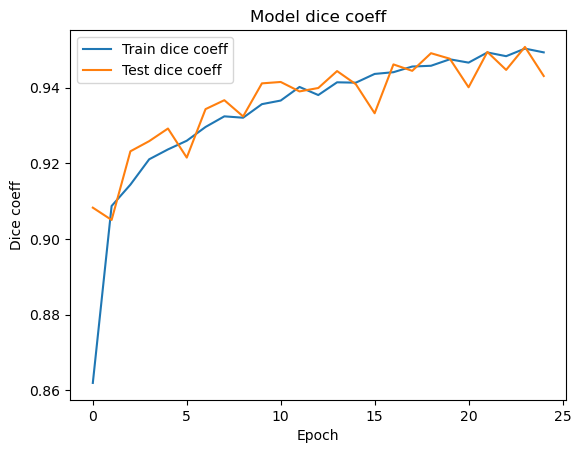

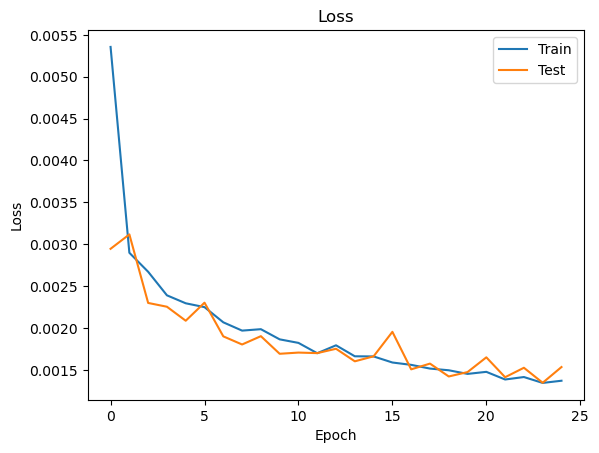

In [45]:
#Plot accuracy results
plt.plot(history.history['F1/DSC'])
plt.plot(history.history['val_F1/DSC'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train dice coeff', 'Test dice coeff'], loc='best')
plt.show()

#Plot loss results
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

# Save Model and History

In [46]:
#Sets the directory to save the model
save_folder = 'model/' + save_name + '/'
saved_model = save_folder + save_name + '.h5'
print('File is to be saved in ', save_folder, 'folder ' + 'as', save_name)

File is to be saved in  model/SeARUNet-3_roi_1.1/ folder as SeARUNet-3_roi_1.1


In [47]:
#Saves the entire structure and weights
model.save(saved_model)
print('successfully saved in as', saved_model)

/home/vplab-2024/miniconda3/envs/s3ar-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


successfully saved in as model/SeARUNet-3_roi_1.1/SeARUNet-3_roi_1.1.h5


In [48]:
import os
#Save the History
save_h(save_folder, history.history)

NameError: name 'os' is not defined

In [ ]:
#Load the History
history = load_h(model_name)

print(model_name, "history loaded!")

In [49]:
# Loads the entire structure and weights
model = load_model(saved_model, compile=False)

In [50]:
model_path = '/home/vplab-2024/Desktop/VoiceLab/segmentation_glottis/models/UNets/S3AR-UNet/s3ar_unet/model/SeARUNet-3_roi_1.1/SeARUNet-3_roi_1.1.h5'
model = load_model(model_path, compile=False)

# EVALUATION

In [51]:

TEST_PATH = "/home/vplab-2024/Desktop/VoiceLab/segmentation_glottis/datasets/BAGLS_VMUNET/test"
(test_x, test_y) = test_loader(TEST_PATH)

print("Test images: ", len(test_x))
print("Test mask: ", len(test_y))

Test images:  3500
Test mask:  3500


In [52]:
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

In [53]:
test_step = (len(test_x) // batch_size)

In [54]:
#Compile the model
model.compile(optimizer=optimizer(learning_rate=learning_rate), 
              loss=tf.keras.losses.BinaryFocalCrossentropy(), 
              metrics=['accuracy', 
                       sm.metrics.Precision(threshold = 0.5, smooth=smooth),
                       sm.metrics.Recall(threshold = 0.5, smooth=smooth),
                       sm.metrics.FScore(threshold = 0.5, smooth=smooth, name='F1/DSC'),   
                       sm.metrics.IOUScore(threshold = 0.5, smooth=smooth, name='IOU/JaccardIndex'),
                       sm.metrics.IOUScore(threshold = 0.5, smooth=smooth, per_image=True, name='MeanIOU')])  

print('Selected optimizer:', optimizer.__name__)
print('Learning rate:', learning_rate)

print('-'*26)
print(' '*4 +'--Model compiled--')
print('-'*26)

Selected optimizer: RMSprop
Learning rate: 0.001
--------------------------
    --Model compiled--
--------------------------


In [55]:
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

test_steps = (len(test_x)//batch_size)
if len(test_x) % batch_size != 0:
    test_steps += 1

In [56]:
model.evaluate(test_dataset, steps=test_steps, return_dict=True)

219/219 [==============================] - 6s 13ms/step - loss: 0.0046 - accuracy: 0.9917 - precision: 0.9343 - recall: 0.7951 - F1/DSC: 0.8569 - IOU/JaccardIndex: 0.7524 - MeanIOU: 0.6824


{'loss': 0.004550245590507984,
 'accuracy': 0.9917360544204712,
 'precision': 0.934344470500946,
 'recall': 0.7950572371482849,
 'F1/DSC': 0.8568716049194336,
 'IOU/JaccardIndex': 0.7524271011352539,
 'MeanIOU': 0.6823580265045166}

In [60]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

model.compile(
    optimizer=opt,
    loss=tf.keras.losses.BinaryFocalCrossentropy(),
    metrics=[
        'accuracy',
        sm.metrics.Precision(threshold=0.5, smooth=smooth),
        sm.metrics.Recall(threshold=0.5, smooth=smooth),
        sm.metrics.FScore(threshold=0.5, smooth=smooth, name='F1/DSC'),
        sm.metrics.IOUScore(threshold=0.5, smooth=smooth, name='IOU/JaccardIndex'),
        sm.metrics.IOUScore(threshold=0.5, smooth=smooth, per_image=True, name='MeanIOU'),
    ],
    jit_compile=False,   # <-- CLAVE para evitar XLA
)
print('Selected optimizer:', optimizer.__name__)
print('Learning rate:', learning_rate)

print('-'*26)
print(' '*4 +'--Model compiled--')
print('-'*26)

Selected optimizer: RMSprop
Learning rate: 0.001
--------------------------
    --Model compiled--
--------------------------


In [58]:
model.evaluate(test_dataset, steps=test_steps, return_dict=True)

219/219 [==============================] - 4s 11ms/step - loss: 0.0046 - accuracy: 0.9917 - precision: 0.9343 - recall: 0.7951 - F1/DSC: 0.8569 - IOU/JaccardIndex: 0.7524 - MeanIOU: 0.6824


{'loss': 0.004550245590507984,
 'accuracy': 0.9917360544204712,
 'precision': 0.934344470500946,
 'recall': 0.7950572371482849,
 'F1/DSC': 0.8568716049194336,
 'IOU/JaccardIndex': 0.7524271011352539,
 'MeanIOU': 0.6823580265045166}